# SBI for the parameters of a line fit
The goal is to do inference and then sample from the inferred parameters to build a posterior predictive check (of y). Then, measure the distribution of y given x, and from this return some sort of error interval.

## 1 Import all the things

In [1]:
## first, import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [2]:
import sbi
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi import analysis as analysis
from sbi.inference.base import infer
import torch

In [3]:
# this is necessary to import modules from this repo
import sys
sys.path.append('..')
from src.scripts import models, utils, train

## 2 Define and test out the simulator
Like any good SBI code, you should start with the simulator. Here, each invocation of the simulator will produce a set of noisy points along a line. In other words, each invocation is defined by a noise width, m, and b.

In [4]:
true_sigma = 10
def simulator(thetas):#, percent_errors):
    # convert to numpy array (if tensor):
    thetas = np.atleast_2d(thetas)
    # Check if the input has the correct shape
    if thetas.shape[1] != 2:
        raise ValueError("Input tensor must have shape (n, 2) where n is the number of parameter sets.")

    # Unpack the parameters
    if thetas.shape[0] == 1:
        # If there's only one set of parameters, extract them directly
        m, b = thetas[0, 0], thetas[0, 1]
    else:
        # If there are multiple sets of parameters, extract them for each row
        m, b = thetas[:, 0], thetas[:, 1]
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    # I'm thinking sigma could actually be a function of x
    # if we want to get fancy down the road
    # Generate random noise (epsilon) based on a normal distribution with mean 0 and standard deviation sigma
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size=(len(x), thetas.shape[0]))
    
    # Initialize an empty array to store the results for each set of parameters
    y = np.zeros((len(x), thetas.shape[0]))
    for i in range(thetas.shape[0]):
        m, b = thetas[i, 0], thetas[i, 1]
        y[:, i] = m * x + b + ε[:, i]
    return torch.Tensor(y.T)

def simulator_no_noise(thetas):#, percent_errors):
    # just plop the pendulum within here
    m, b = thetas
    x = np.linspace(0, 100, 101)
    return m * x + b

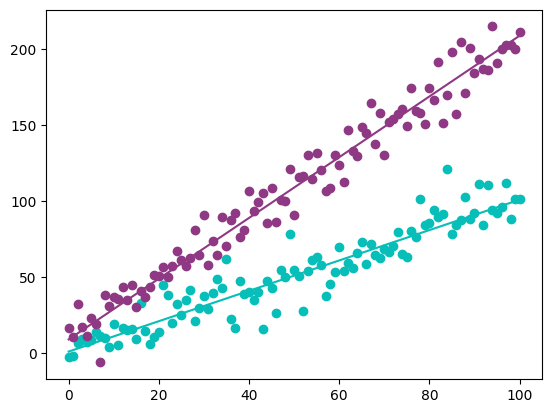

In [9]:
plt.scatter(np.linspace(0, 100, 101),
            np.array(simulator([1, 1])), color = '#07BEB8')
plt.plot(np.linspace(0, 100, 101),
            np.array(simulator_no_noise([1, 1])), color = '#07BEB8')
plt.scatter(np.linspace(0, 100, 101),
            np.array(simulator([2, 9])), color = '#8F3985')
plt.plot(np.linspace(0, 100, 101),
            np.array(simulator_no_noise([2, 9])), color = '#8F3985')
plt.show()

## 3 Generate data
This part is a placeholder for future work - 

Each data "point" is a set of points corresponding to a slope and intercept. The potential future hierarchical aspect of this is inferring things about the distribution of lines in the universe.

The effective data length is 1000 x 100 (because there are 100 x points per each data point).

In [ ]:
length_df = 1000
xs = np.zeros((length_df, 2))
ys = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.normal(loc=1, scale=1)
    b = rs.normal(loc=0, scale=10)
    #sigma = abs(rs.normal(loc=0, scale=10))
    thetas = [m, b]
    xs[r,:] = thetas
    ys.append(simulator(thetas))

In [ ]:
print(np.shape(xs), np.shape(ys))

## 4 Define the prior
And then visualize them.

In [10]:
num_dim = 2

low_bounds = torch.tensor([0, -10])
high_bounds = torch.tensor([10, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)

<Figure size 640x480 with 0 Axes>

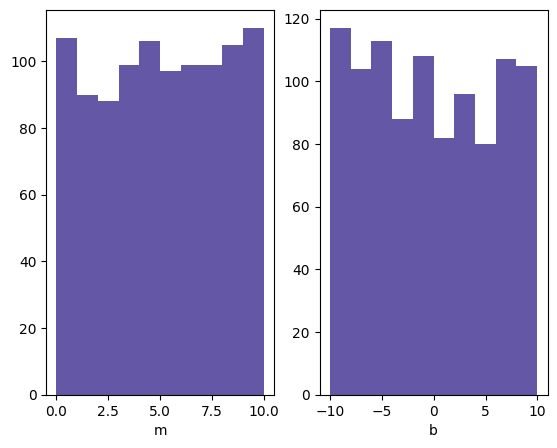

In [11]:
m_sample = []
b_sample = []

for i in range(1000):
  samp = prior.sample()
  m_sample.append(np.array(samp[0]))
  b_sample.append(np.array(samp[1]))

plt.clf()
fig = plt.figure(figsize = (10,5))
ax0 = fig.add_subplot(131)
ax0.hist(m_sample, color = '#6457A6')
ax0.set_xlabel('m')
ax1 = fig.add_subplot(132)
ax1.hist(b_sample, color = '#6457A6')
ax1.set_xlabel('b')
plt.show()

## 5 Run SBI
Normalizing flow; neural network magic.

In [12]:
posterior = infer(simulator, prior, "SNPE", num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 100 epochs.

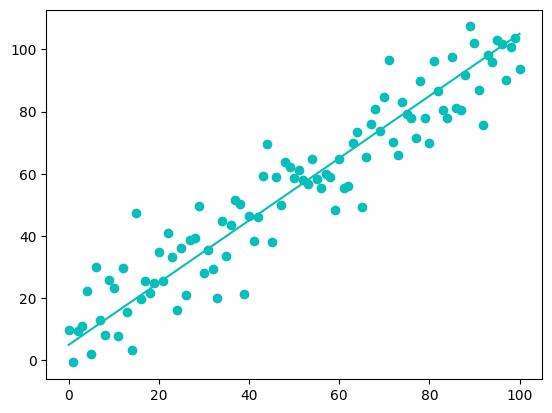

In [14]:
# generate a true dataset
theta_true = [1, 5]
y_true = simulator(theta_true)
y_true_no_noise = simulator_no_noise(theta_true)

# and visualize it
plt.clf()
plt.scatter(np.linspace(0, 100, 101),
            np.array(y_true), color = '#07BEB8')
plt.plot(np.linspace(0, 100, 101),
            np.array(y_true_no_noise), color = '#07BEB8')
plt.show()



Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

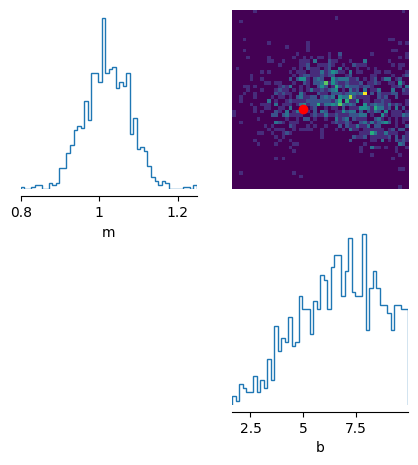

In [15]:
# sample from the posterior
posterior_samples_1 = posterior.sample((1000,), x = y_true)

# plot posterior samples
fig, axes = analysis.pairplot(
    posterior_samples_1, 
    labels = ['m', 'b'],
    #limits = [[0,10],[-10,10],[0,10]],
    truths = theta_true,
    figsize=(5, 5)
)
axes[0, 1].plot([theta_true[1]], [theta_true[0]], marker="o", color="r")

## 6 Posterior predictive
Okay but these are just the parameters. What we really want is the posterior predictive check, which is built by running draws from the posterior through the simulator again.

With or without noise in the simulator? I think without because otherwise it would be double counting uncertainty.

In [16]:
# first the way of the sbi module
# Generate predictive samples by simulating from posterior samples.
posterior_predictive_samples = simulator(posterior_samples_1)
print(np.shape(posterior_predictive_samples), posterior_predictive_samples)

torch.Size([1000, 101]) tensor([[ 17.4502,  17.9217,  33.7169,  ..., 102.6395, 113.4168, 121.3570],
        [  1.2513,   4.9664,  17.7063,  ..., 109.1014,  92.2587,  88.0874],
        [  6.5785,  17.0459,  18.1162,  ..., 124.8528, 111.5362, 115.6801],
        ...,
        [ -4.7824,  -5.0179,  15.4508,  ..., 117.2514, 110.9497, 109.2980],
        [  2.1804,   2.1702,  11.1269,  ...,  82.8779,  81.2181,  79.9294],
        [  7.5211,  -3.8021,  -3.5819,  ..., 107.6035,  97.9408, 109.8663]])


In [ ]:
# let's do some posterior predictive checks to see if the
# posterior predictive samples cluster around the observation `y_true`.
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_predictive_samples,
    points=y_true,
    #limits=list(zip(y_true.flatten() - 1.0, y_true.flatten() + 1.0)),
    offdiag="kde",
    diag="kde",
    figsize=(5, 5),
    #labels=[rf"$x_{d}$" for d in range(3)],
)

Writing my own code to visualize what the PPC looks like in terms of fitting a line:

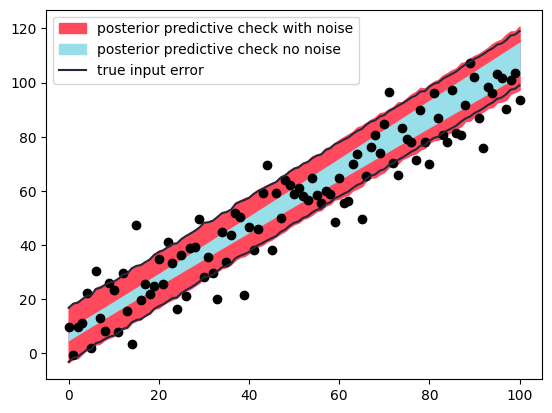

In [19]:
# also go through and plot one sigma interval
# plot the true values
plt.clf()
xs_sim = np.linspace(0, 100, 101)
ys_sim = np.zeros((np.shape(posterior_samples_1)[0], len(xs_sim)))
ys_sim_no_noise = np.zeros((np.shape(posterior_samples_1)[0], len(xs_sim)))
# for every posterior sample, run it through the no noise and the noisy simulator
for j in range(np.shape(posterior_samples_1)[0]):
    ys_sim_no_noise[j,:] = simulator_no_noise(posterior_samples_1[j,:])
    ys_sim[j,:] = simulator(posterior_samples_1[j,:])

plt.fill_between(xs_sim,
                 np.mean(ys_sim, axis = 0) - 1 * np.std(ys_sim, axis = 0),
                 np.mean(ys_sim, axis = 0) + 1 * np.std(ys_sim, axis = 0),
                 color = '#FF495C', label = 'posterior predictive check with noise')
plt.fill_between(xs_sim,
                 np.mean(ys_sim_no_noise, axis = 0) - 1 * np.std(ys_sim_no_noise, axis = 0),
                 np.mean(ys_sim_no_noise, axis = 0) + 1 * np.std(ys_sim_no_noise, axis = 0),
                 color = '#98DFEA', label = 'posterior predictive check no noise')

plt.plot(xs_sim, np.mean(ys_sim, axis = 0) + true_sigma,
         color = '#25283D', label = 'true input error')
plt.plot(xs_sim, np.mean(ys_sim, axis = 0) - true_sigma,
         color = '#25283D')
plt.scatter(xs_sim,
            np.array(y_true), 
            color = 'black')#'#EFD9CE')    
plt.legend()

plt.show()

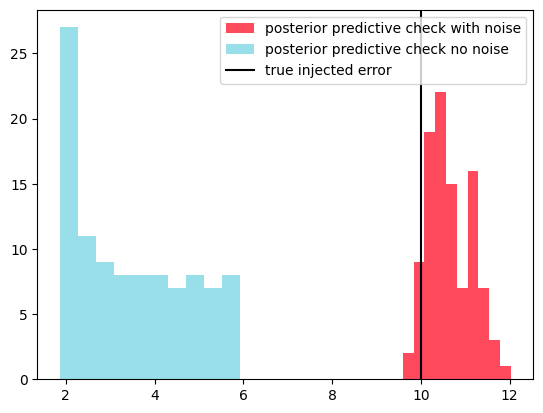

In [20]:
# Another way to look at this would be to plop it on its side and look at the sigma values at each x
plt.hist(np.std(ys_sim, axis = 0),
         label = 'posterior predictive check with noise',
         color = '#FF495C',
         bins = 10)
plt.hist(np.std(ys_sim_no_noise, axis = 0),
         label = 'posterior predictive check no noise',
         color = '#98DFEA',
         bins = 10)
plt.axvline(x = true_sigma,
            color = 'black',
            label = 'true injected error')
plt.legend()
plt.show()

## 7 SBC

In [24]:
from sbi.analysis import run_sbc, sbc_rank_plot, check_sbc
num_sbc_runs = 1_000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
ys = simulator(thetas)

# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    thetas, ys, posterior, num_posterior_samples=num_posterior_samples
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)
check_stats

{'ks_pvals': tensor([8.2151e-09, 8.7516e-04]),
 'c2st_ranks': tensor([0.6030, 0.5850]),
 'c2st_dap': tensor([0.5030, 0.5145])}

The ks pvalues are vanishingly small here, so we can reject the null hypothesis (of the marginal rank distributions being equivalent to an uniform distribution). The inference clearly went wrong.
In terms of the c2st_ranks diagnostic; this is a nonparametric two sample test from training on and testing on the rank versus uniform distributions and distinguishing between them. If values are close to 0.5, it is hard to distinguish.
The data-averaged posterior value compares to the prior; if these values are close to 0.5, dap is like the prior distribution.

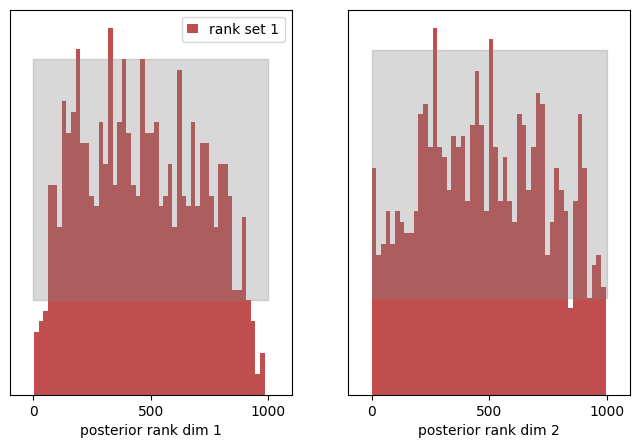

In [26]:
_ = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,
)

Some of these bars are outside the grey uniform area and the overall shape is Gaussian, meaning that the posterior estimate is narrower than expected from the true posterior?

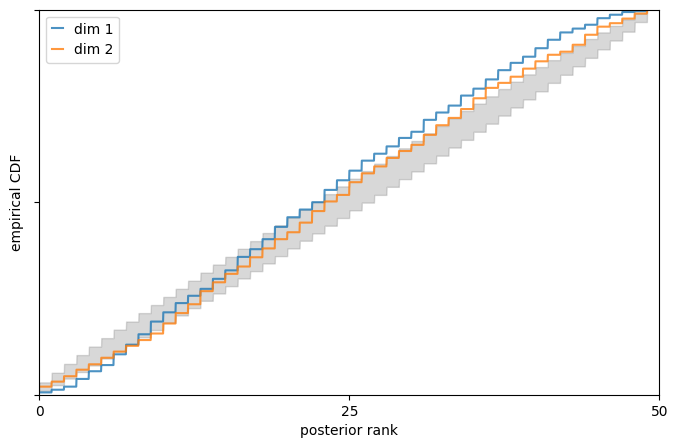

In [28]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

## 6 Use the analysis module to assess the posterior

In [ ]:
from sbi.analysis import run_sbc, sbc_rank_plot

thetas = prior.sample((3,))
print(thetas)
posterior_samples = posterior.sample((3,), x = y_true)
print(posterior_samples)


ys = simulator(thetas)
print(np.shape(thetas),np.shape(ys))

num_posterior_samples = 1000

ranks, dap_samples = run_sbc(
    thetas, ys, posterior, num_posterior_samples=num_posterior_samples
)

_ = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=5,
)